In [179]:
import scipy.io as scio
import pandas as pd
import numpy as np
import os
from pandas import Series,DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import accuracy_score  
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

import time
import cProfile

sns.set()

### Set Path 

In [175]:
#Fall2019-proj3-sec1--proj3-sec1-grp2
pwd = os.path.dirname(os.path.dirname(os.getcwd()))
    
# set the working directory of output
checkpoint_wd = os.path.join(pwd, "output", "checkpoint")
if not os.path.exists(checkpoint_wd):
    os.makedirs(checkpoint_wd)

## Train 

### Data Preprocessing 

In [2]:
scaler = MinMaxScaler(feature_range = (0,1))

In [3]:
random.seed(3345)

In [4]:
def distance_feature(x): # calcuate distance between points, choose uprigt triangle
    #sqrt(dx^2+dy^2)
    a = (x[None, :, :] - x[:, None, :])
    b = np.linalg.norm(a, axis=2)
    return b[np.triu_indices(78, 1)] # feature size (78-1)(78-2) /2 

In [5]:
def euc_distance_feature(x): # instead of distance, keep two dimensional distance vector
    #(dx,dy)
    a = (x[None, :, :] - x[:, None, :])
    index = np.triu_indices(78, 1)
    b = a[index]
    return b.reshape((-1,)) # feature size (78-1)(78-2) /2 * 2

In [6]:
df = pd.read_csv("../../data/train_set/label.csv")
labels = df["emotion_idx"].tolist()

In [7]:
data = list()
for i in range(1, 2501):
    name = "../../data/train_set/points/%04d.mat" % i
    dic = scio.loadmat(name)
    if "faceCoordinatesUnwarped" in dic:
        data.append(dic["faceCoordinatesUnwarped"])
    else:
        data.append(dic["faceCoordinates2"])

In [8]:
# shuffle data
data, labels = shuffle(data, labels, random_state=0)

In [9]:
x_train, x_test, train_y, test_y = train_test_split(data, labels, test_size=0.2)

### First we try euclidien distance as features 

In [69]:
train_x = [euc_distance_feature(d) for d in x_train]
test_x = [euc_distance_feature(d) for d in x_test]

In [70]:
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [71]:
start = time.time()
clf = LogisticRegression(max_iter=300, penalty = "l2", solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit(train_x, train_y)
end = time.time()
print("Training Time:","%s seconds"%(end - start))

Training Time: 34.474689960479736 seconds


In [72]:
print("Training dataset Accuracy")
train_accuracy = clf.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = clf.score(test_x, test_y) 
print(test_accuracy)

Training dataset Accuracy
0.823
Testing dataset Accuracy
0.534


xgboost

In [74]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x, label=test_y)

In [77]:
param = {'booster':'gbtree',
'objective': 'multi:softmax', 
'num_class':23,
'gamma':0.05,  
'max_depth':4, 
'silent':1 ,
'subsample': 0.4,
'eta': 0.001}
num_round=2
start = time.time()
bst = xgb.train(param, dtrain, num_round)
end = time.time()
print("Training Time:","%s seconds"%(end - start))
train_preds = bst.predict(dtrain)
train_accuracy = accuracy_score(train_y, train_preds) 
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))

Training Time: 33.16583228111267 seconds
Train Accuary: 52.40%


In [78]:
test_preds = bst.predict(dtest)
test_accuracy = accuracy_score(test_y, test_preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 26.80%


### Second we try the distance as features 

In [59]:
train_x = [distance_feature(d) for d in x_train]
test_x = [distance_feature(d) for d in x_test]

In [60]:
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

GBM 

In [97]:
start = time.time()
gbm = GradientBoostingClassifier(learning_rate=0.01,n_estimators=30,random_state=10).fit(train_x, train_y)
end = time.time()
print("Training Time:","%s seconds"%(end - start))

Training Time: 314.04456615448 seconds


In [98]:
print("Training dataset Accuracy")
train_accuracy = gbm.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
gbm_preds = gbm.predict(test_x)
test_accuracy = gbm.score(test_x, test_y) 
print(test_accuracy)

Training dataset Accuracy
0.6665
Testing dataset Accuracy
0.336


Logistic Regression

In [99]:
start = time.time()
clf = LogisticRegression(max_iter=300, penalty = "l2", solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit(train_x, train_y)
end = time.time()
print("Training Time:","%s seconds"%(end - start))

Training Time: 17.512210845947266 seconds


In [101]:
print("Training dataset Accuracy")
train_accuracy = clf.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
lr_preds = clf.predict(test_x)
test_accuracy = clf.score(test_x, test_y) 
print(test_accuracy)

Training dataset Accuracy
0.8035
Testing dataset Accuracy
0.524


Random Forest

In [102]:
forest = RandomForestClassifier(n_estimators=400, oob_score = True, 
                                max_depth=15, max_leaf_nodes=15,
                                max_features="auto", n_jobs=-1)

In [103]:
start = time.time()
forest.fit(train_x, train_y)
end = time.time()
print("Training Time:","%s seconds"%(end - start))
print("Training dataset Accuracy")
train_accuracy = forest.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
rf_preds = forest.predict(test_x)
test_accuracy = forest.score(test_x, test_y) 
print(test_accuracy)

Training Time: 4.506240129470825 seconds
Training dataset Accuracy
0.455
Testing dataset Accuracy
0.304


xgboost

In [212]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x, label=test_y)
param = {'booster':'gbtree',
'objective': 'multi:softmax', 
'num_class':23,
'n_estimators':100,
'max_depth':20, 
'alpha': 3,
'gamma': 1,
'silent': 1,
'subsample': 0.8,
'eta': 0.1,
'learning_rates': 0.03}
num_round= 5
start = time.time()
bst = xgb.train(param, dtrain, num_round)
end = time.time()
print("Training Time:","%s seconds"%(end - start))
train_preds = bst.predict(dtrain)
train_accuracy = accuracy_score(train_y, train_preds) 
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))

Training Time: 72.87692213058472 seconds
Train Accuary: 87.60%


In [213]:
xgb_preds = bst.predict(dtest)
test_accuracy = accuracy_score(test_y, xgb_preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 36.40%


### KNN

In [90]:
train_x = [distance_feature(d) for d in x_train]
test_x = [distance_feature(d) for d in x_test]

In [91]:
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

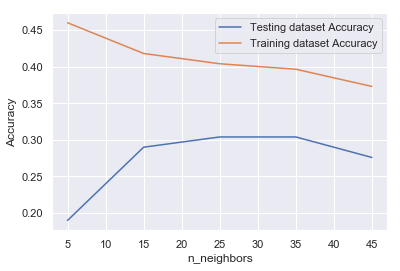

In [81]:
neighbors = np.arange(5, 50, 10) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
# Loop over K values 
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(train_x, train_y) 
      
    # Compute traning and test data accuracy 
    train_accuracy[i] = knn.score(train_x, train_y) 
    test_accuracy[i] = knn.score(test_x, test_y) 

#Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

In [92]:
start = time.time()
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_x, train_y) 
end = time.time()
print("Training Time:","%s seconds"%(end - start))

Training Time: 0.1534569263458252 seconds


In [93]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
knn_preds = knn.predict(test_x)
test_accuracy = knn.score(test_x, test_y) 
print(test_accuracy)

Training dataset Accuracy
0.415
Testing dataset Accuracy
0.262


In [94]:
pca = PCA(n_components=48).fit(train_x)
train_x_reduce = pca.transform(train_x)

In [95]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_x_reduce, train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

In [96]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x_reduce, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = knn.score(pca.transform(test_x), test_y) 
print(test_accuracy)

Training dataset Accuracy
0.416
Testing dataset Accuracy
0.258


### Model Ensembling

Method 1: Average

In [169]:
preds = (lr_preds+knn_preds+rf_preds+gbm_preds)/4
preds = np.ceil(preds)
test_accuracy = accuracy_score(test_y, preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 18.20%


In [143]:
preds = (lr_preds+rf_preds+gbm_preds)/3
preds = np.ceil(preds)
test_accuracy = accuracy_score(test_y, preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 25.00%


In [171]:
preds = (lr_preds+gbm_preds)/2
preds = np.ceil(preds)
test_accuracy = accuracy_score(test_y, preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 33.00%


Method 2: Stacking

In [153]:
#Method 2: Stacking
from sklearn.model_selection import KFold
def stacking(clf, x_train, y_train, x_test, n_folds=8):
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,))
    second_level_test_set = np.zeros((test_num,))
    test_nfolds_sets = np.zeros((test_num, n_folds))
    kf = KFold(n_splits=n_folds)

    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        x_tra, y_tra = x_train[train_index], y_train[train_index]
        x_tst, y_tst =  x_train[test_index], y_train[test_index]

        clf.fit(x_tra, y_tra)

        second_level_train_set[test_index] = clf.predict(x_tst)
        test_nfolds_sets[:,i] = clf.predict(x_test)

    second_level_test_set[:] = test_nfolds_sets.mean(axis=1)
    return second_level_train_set, second_level_test_set

In [154]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [172]:
gbm_model = GradientBoostingClassifier(learning_rate=0.01,n_estimators=30,random_state=10)
lr_model = LogisticRegression(max_iter=300, penalty = "l2", solver='lbfgs', multi_class='multinomial', n_jobs=-1)

In [173]:
train_sets = []
test_sets = []
for clf in [gbm_model,lr_model]:
    train_set, test_set = stacking(clf, train_x, train_y, test_x)
    train_sets.append(train_set)
    test_sets.append(test_set)

meta_train = np.concatenate([result_set.reshape(-1,1) for result_set in train_sets], axis=1)
meta_test = np.concatenate([y_test_set.reshape(-1,1) for y_test_set in test_sets], axis=1)

In [174]:
model = DecisionTreeClassifier(max_depth = 5)
model.fit(train_x,train_y)
print(model.score(train_x, train_y))
model.score(test_x, test_y)

0.379


0.278

Save Model

In [180]:
joblib.dump(clf, checkpoint_wd+"/train_model.m")

['/Users/yuting/Desktop/MS&E_3/Applied DS/Fall2019-proj3-sec1--proj3-sec1-grp2/output/checkpoint/train_model.m']

## Test 

In [181]:
pwd = os.path.dirname(os.path.dirname(os.getcwd()))
checkpoint_wd = os.path.join(pwd, "output", "checkpoint")

In [182]:
# read model
clf = joblib.load(checkpoint_wd+"/train_model.m")

In [ ]:
# read label
data_path = os.path.join(pwd, "data", "test_set")
df = pd.read_csv(data_path +"/label.csv")
labels = df["emotion_idx"].tolist()

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))

In [ ]:
def distance_feature(x): # calcuate distance between points, choose uprigt triangle
    #sqrt(dx^2+dy^2)
    a = (x[None, :, :] - x[:, None, :])
    b = np.linalg.norm(a, axis=2)
    return b[np.triu_indices(78, 1)] # feature size (78-1)(78-2) /2 

In [ ]:
# read point
data = list()
for i in range(1, 2501):
    name = "../../data/test_set/points/%04d.mat" % i
    dic = scio.loadmat(name)
    if "faceCoordinatesUnwarped" in dic:
        data.append(dic["faceCoordinatesUnwarped"])
    else:
        data.append(dic["faceCoordinates2"])

In [ ]:
test_x = [distance_feature(d) for d in data]
scaler.fit(test_x)
test_x = scaler.transform(test_x)

In [ ]:
preds = clf.predit(test_x)
test_accuracy = accuracy_score(labels, preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))